In [1]:
directory = '/Users/davidkarapetyan/Documents/workspace/data_analysis/'
csv_file = 'data/park345_FL17_NE_air.csv'

import pandas as pd
# for wide terminal display of pandas dataframes
pd.options.display.width = 120
pd.options.display.max_rows = 10000
import numpy as np
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.statespace.sarimax as sarimax

# plot inline
%pylab inline
# IPython.get_ipython().magic('matplotlib inline')
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 14, 6


# load dataframe, and subset out relevant columns
park_data = pd.read_csv(directory + csv_file, error_bad_lines=False)
park_data.columns = ['ID', 'TIMESTAMP',
'TRENDFLAGS', 'STATUS',
'VALUE', 'TRENDFLAGS_TAG',
'STATUS_TAG']
park_data = park_data.sort('TIMESTAMP')


# construct time series, getting rid of microseconds
park_ts = pd.Series(list(park_data.VALUE),
pd.DatetimeIndex(park_data.TIMESTAMP),
name="steam values")

park_ts = park_ts.loc[park_ts != 0].resample('15Min ', fill_method='pad')
print(park_ts)

Populating the interactive namespace from numpy and matplotlib
2013-03-20 02:15:00     74.890900
2013-03-20 02:30:00     74.942810
2013-03-20 02:45:00     75.098480
2013-03-20 03:00:00     75.098480
2013-03-20 03:15:00     75.150391
2013-03-20 03:30:00     75.098480
2013-03-20 03:45:00     75.098480
2013-03-20 04:00:00     75.098480
2013-03-20 04:15:00     75.098480
2013-03-20 04:30:00     75.098480
2013-03-20 04:45:00     75.150391
2013-03-20 05:00:00     75.046600
2013-03-20 05:15:00     75.098480
2013-03-20 05:30:00     75.046600
2013-03-20 05:45:00     73.775116
2013-03-20 06:00:00     72.918793
2013-03-20 06:15:00     74.294067
2013-03-20 06:30:00     74.787109
2013-03-20 06:45:00     75.150391
2013-03-20 07:00:00     75.254181
2013-03-20 07:15:00     75.409851
2013-03-20 07:30:00     75.461761
2013-03-20 07:45:00     75.643372
2013-03-20 08:00:00     75.695282
2013-03-20 08:15:00     75.851013
2013-03-20 08:30:00     75.954803
2013-03-20 08:45:00     75.357971
2013-03-20 09:00:00

In [2]:
print(arima.ARIMA(park_ts, (0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                34966
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -55180.887
Method:                           css   S.D. of innovations              1.173
Date:                Tue, 07 Jul 2015   AIC                         110365.773
Time:                        13:43:53   BIC                         110382.698
Sample:                    03-20-2013   HQIC                        110371.164
                         - 03-19-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0050      0.006      0.799      0.425        -0.007     0.017


We see that ARIMA is not currently fitting the time series data. We look for
an appropriate transformation of the time series to improve our ARIMA fitting.

###Log Ratio Transformation

To get a properly scaled plot, we filter out the outlier values occuring at
the end of day (shift from some steam usage to none at all as systems
restart, and spikes from ramp-up time at the beginning of the day).

count    34966.000000
mean         0.000034
std          0.011669
min         -0.129839
5%          -0.008554
50%          0.000000
95%          0.008007
max          1.286595
Name: steam values, dtype: float64


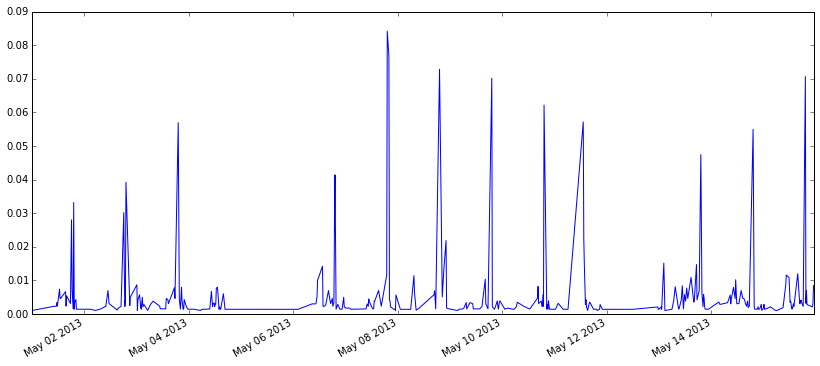

In [3]:
park_ts_logr = (np.log(park_ts / park_ts.shift(1)))[1:]
print(park_ts_logr.describe(percentiles=[0.05, 0.95]))

park_ts_logr[(park_ts_logr > 0.001) & (park_ts_logr < 0.23)][
'2013-05-01': '2013-05-15'].plot()

The seasonality is clear. We now plot a single day, filtering out
outliers to get a properly scaled figure.

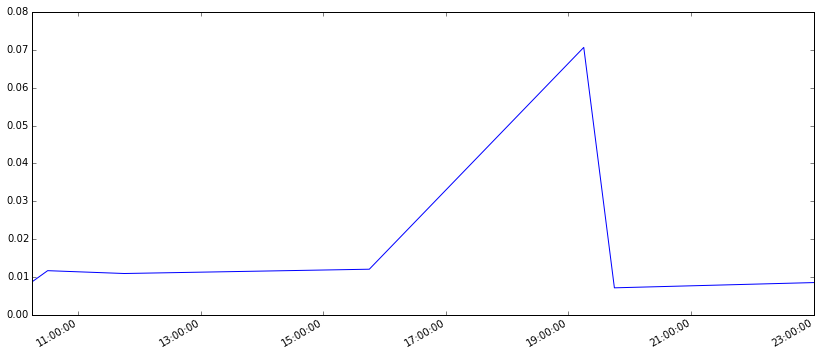

In [4]:
park_ts_logr[(park_ts_logr > 0.005) & (park_ts_logr < 0.18)][
'2013-05-15'].plot()

Next, we utilise a SARIMAX model, with seasonality at 96
(our data points are spaced at 15 minute intervals),
and analyze a week's worth of data (starting on Monday, and ending on Friday).

In [5]:
print(sarimax.SARIMAX(park_ts_logr.loc['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood                1221.611
Date:                            Tue, 07 Jul 2015   AIC                          -2439.222
Time:                                    13:43:55   BIC                          -2430.874
Sample:                                05-06-2013   HQIC                         -2435.941
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.2134      0.049     -4.371      0.000        -0.309    -0.118
sigma2         0.0001   7.31e-06     13.801      0.000      8.66e-05     0.000


While the fit isn't terrible, it can be improved by first observing
that we have spikes in our at the beginning of the day. This is due to
the ratio of chilled water temperature dipping suddenly at the end of day
as systems are ramped down.
Observe that the only negative values in the data occur at the start of
day. We filter these out, and re-run SARIMA.

In [6]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  195
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                 270.002
Date:                            Tue, 07 Jul 2015   AIC                           -536.004
Time:                                    13:43:56   BIC                           -529.458
Sample:                                05-06-2013   HQIC                          -533.353
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.2626      0.090      2.915      0.004         0.086     0.439
sigma2         0.0003   3.65e-05      7.238      0.000         0.000     0.000


Our data is clustered very close to the mean--i.e, the spikes are very small spikes. Consequently, the positive of filtering them out (i.e. smoothing the data) outweighs the drawback of reducing the number of points to fit. 

Now, let's use a larger input
(beginning on a Monday, and ending on a Friday), and fit another
Sarimax model to our beginning-of-day spike-filtered data.

In [7]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-06-07'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 1386
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                3799.174
Date:                            Tue, 07 Jul 2015   AIC                          -7594.348
Time:                                    13:44:06   BIC                          -7583.880
Sample:                                05-06-2013   HQIC                         -7590.433
                                     - 06-07-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.1390      0.027      5.147      0.000         0.086     0.192
sigma2         0.0002   6.63e-06     24.530      0.000         0.000     0.000


/Users/davidkarapetyan/Library/Python/3.4/lib/python/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


As expected, this is an even better fit than the fit for the week's worth of data.
Lastly, we input three # months worth of data, beginning on a Monday,
and ending on a Friday.

In [8]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr > 0]['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4101
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               11901.656
Date:                            Tue, 07 Jul 2015   AIC                         -23799.311
Time:                                    13:44:14   BIC                         -23786.673
Sample:                                05-06-2013   HQIC                        -23794.837
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.1834      0.015     12.233      0.000         0.154     0.213
sigma2         0.0002   3.27e-06     47.066      0.000         0.000     0.000


Let's contrast this with our fit when we include the end-of-day spikes:

In [9]:
print(sarimax.SARIMAX(park_ts_logr['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 9120
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood               27853.537
Date:                            Tue, 07 Jul 2015   AIC                         -55703.075
Time:                                    13:44:26   BIC                         -55688.838
Sample:                                05-06-2013   HQIC                        -55698.234
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.1374      0.010     13.412      0.000         0.117     0.158
sigma2         0.0001   1.88e-06     64.826      0.000         0.000     0.000


Hence, it makes sense to keep the analysis of
15-minute ramp-up and ramp-down times together with the analysis of the remaining data.

##SARIMAX on Data for Individual Days

We next investigate seasonality on a weekly basis. That is, we
isolate the 5-day workweek into 5 chunks, and run SARIMAX on
each chunk separately.

In [10]:
print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 1,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 2,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 3,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 4,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 1943
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                5365.508
Date:                            Tue, 07 Jul 2015   AIC                         -10727.016
Time:                                    13:44:40   BIC                         -10715.872
Sample:                                03-25-2013   HQIC                        -10722.919
                                     - 02-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.1750      0.022      7.890      0.000         0.132     0.218
sigma2         0.0002   5.51e-06     31.966      0.000         0.000     0.000
                                 Statespace Mod

/Users/davidkarapetyan/Library/Python/3.4/lib/python/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Including the spikes gives:

In [11]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 0],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 1],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 2],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 3],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 4],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4992
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               14364.996
Date:                            Tue, 07 Jul 2015   AIC                         -28725.991
Time:                                    13:45:25   BIC                         -28712.960
Sample:                                03-25-2013   HQIC                        -28721.424
                                     - 03-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.0411      0.014     -2.883      0.004        -0.069    -0.013
sigma2         0.0002   3.37e-06     49.224      0.000         0.000     0.000
                                 Statespace Mod

##ARIMAX For Ramp-up and Ramp-Down

We shall treat Monday ramp-ups separately from the remaining days of the week,
due to difference between system-idling over weekends and weekdays.

In [12]:
print(arima.ARIMA(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)],
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                 1847
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5485.799
Method:                           css   S.D. of innovations              0.012
Date:                Tue, 07 Jul 2015   AIC                         -10967.598
Time:                        13:46:27   BIC                         -10956.555
Sample:                    03-25-2013   HQIC                        -10963.527
                         - 02-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -4.479e-07      0.000     -0.002      0.999        -0.001     0.001


Observe that between end of day and start of day, chilled water temperature
decreases, and so $$\frac{T_k(0 + 00:15)}{T_k(0)} = a_k < 1$$ for each
entry in our training set. The set $\{a_k\}_k$ will hopefully consist of
entries that are clustered near one another, with some reasonable volatility.
Taking a logarithm of them will result in an exponential increase in
volatility, since $log(x)$ is an exponential function of $x$ for decreasing
$x < 1$. This will result in decreasing the goodness-of-fit of a linear
model, from a least-squares standpoint. Consequently, we exponentiate our
time series data, and re-fit:

In [13]:
print(arima.ARIMA(np.exp(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)]),
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                 1847
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5543.996
Method:                           css   S.D. of innovations              0.012
Date:                Tue, 07 Jul 2015   AIC                         -11083.992
Time:                        13:46:27   BIC                         -11072.949
Sample:                    03-25-2013   HQIC                        -11079.921
                         - 02-17-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -4.475e-07      0.000     -0.002      0.999        -0.001     0.001


Observe that the fit has improved, though not dramatically like for some of our other time series. This is due to Monday ramp-up values being very close to the mean. In general, our time series values are clustered very close together throughout the week. 